In [2]:
import gensim
import numpy as np
import pandas as pd
import math
import random
import json
import re
import pickle
import time
import nltk
import os
import io
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats.stats import pearsonr, chisquare
from sklearn.utils import shuffle
from keras.optimizers import adam
from keras.models import load_model

In [3]:
def word_tokenizer(corpus):
    """tokenize a list of posts"""
    
    tokens = []
    for text in corpus:
        if type(text) is not str:
            text = str(text)
        text = re.sub(r'([^A-Za-z0-9 \']+)', r' \1 ', text)
        text = text.replace("\'", "\'")
        tokens.append(text.split())
    return tokens

In [4]:
def sent_tokenizer(corpus):
    """split a paragraph to individual sentences"""
    
    sents = [nltk.tokenize.sent_tokenize(sent) for sent in corpus]
    return sents

In [5]:
def hist_plot(hist, baseline):
    """plot accuracy and loss for a RNN model, compared with baseline accuracy"""
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(baseline)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()
    

In [6]:
with open('data/word2idx.txt', "r") as f:
    word2idx = json.loads(f.read())

with open('data/idx2word.txt', "r") as f:
    idx2word = json.loads(f.read())

with open('data/vocab.txt', "rb") as f:
    vocab = pickle.load(f)

In [84]:
len(vocab)

243607

In [85]:
comment = pd.read_csv('data/combined.csv')
len(comment)

467802

### Embedding training with Word2Vec

In [ ]:
comment = pd.read_csv('data/combined.csv')
post = comment['content'].tolist()
sents = sent_tokenizer(post)

tokenized_sents = []
"""tokenize word in list of sentences"""
for p in sents:
    for sent in p:
        sent = re.sub(r'([^A-Za-z0-9 \']+)', r' \1 ', sent)
        sent = sent.replace('\'', '\'')
        sent = sent.split()
        tokenized_sents.append(sent)

In [14]:
"""word vectors with embed_dim = 100"""
w2v_model = Word2Vec(tokenized_sents, min_count=1, size=100, workers=3, window=5, iter=100)
w2v_model.save('word2vec_model2.model') 
pretrained_weights = w2v_model.wv.vectors

In [ ]:
"""generate vocab, idx2word, and word2idx"""
idx2word = {}
word2idx = {}
for i in range(len(model.wv.index2word)):
    word = model.wv.index2word[i]
    idx2word[i] = word
    word2idx[word] = i

vocab = [*model.wv.vocab]

with open('vocab.txt', "wb") as f:
    pickle.dump(vocab, f)

with open('word2idx.txt', "w") as f:
    f.write(json.dumps(word2idx))
    
with open('idx2word.txt', "w") as f:
    f.write(json.dumps(idx2word))

### Multi-label Classifier with RNN

Training set: 2000

Test set: 200

In [159]:
"""load pre-trained word vectors"""
pretrained_model = gensim.models.Word2Vec.load("w2v_model/word2vec_model2.model")
pretrained_weights = pretrained_model.wv.vectors

In [160]:
max_words = int(len(vocab))
embed_size = 100
max_len = 500
embedding_dim = 100

In [161]:
train_path = 'data/sample_LIWC.csv'
training = pd.read_csv(train_path)
training = shuffle(training)
categories = ['emotional support', 'non-emotional support']

In [162]:
"""distribution"""
training.groupby(['label_e','label_n']).size()

label_e  label_n
0        0            5
         1          889
1        0          192
         1          914
dtype: int64

In [163]:
x_train = word_tokenizer(training['content'].str.lower().tolist())
y_train = training[['label_e', 'label_n']].values
e_train = training[['label_e']].values
n_train = training[['label_n']].values
tf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, lower=True)
tf_tokenizer.fit_on_texts(x_train)

x_train = tf_tokenizer.texts_to_sequences(x_train)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)

In [171]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vocab), embedding_dim, weights = [pretrained_weights]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                                       bias_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dense(embedding_dim, activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(0.001),
                          activity_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 100)         24360700  
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_46 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 202       
Total params: 24,541,802
Trainable params: 24,541,802
Non-trainable params: 0
_________________________________________________________________


In [172]:
num_epoch = 20
opt = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=num_epoch, callbacks=callbacks, verbose=2)

Epoch 1/20
50/50 - 27s - loss: 1.9019 - binary_accuracy: 0.7241 - categorical_accuracy: 0.4419 - val_loss: 1.2976 - val_binary_accuracy: 0.7950 - val_categorical_accuracy: 0.4550
Epoch 2/20
50/50 - 27s - loss: 1.0180 - binary_accuracy: 0.7978 - categorical_accuracy: 0.4769 - val_loss: 0.8509 - val_binary_accuracy: 0.7850 - val_categorical_accuracy: 0.5550
Epoch 3/20
50/50 - 27s - loss: 0.7610 - binary_accuracy: 0.8294 - categorical_accuracy: 0.5194 - val_loss: 0.7211 - val_binary_accuracy: 0.8300 - val_categorical_accuracy: 0.5625
Epoch 4/20
50/50 - 27s - loss: 0.6553 - binary_accuracy: 0.8547 - categorical_accuracy: 0.5819 - val_loss: 0.6731 - val_binary_accuracy: 0.8225 - val_categorical_accuracy: 0.6150
Epoch 5/20
50/50 - 27s - loss: 0.5960 - binary_accuracy: 0.8694 - categorical_accuracy: 0.6344 - val_loss: 0.6424 - val_binary_accuracy: 0.8313 - val_categorical_accuracy: 0.6350
Epoch 6/20
50/50 - 27s - loss: 0.5522 - binary_accuracy: 0.8838 - categorical_accuracy: 0.6500 - val_loss

In [88]:
model.save('support_model.h5')

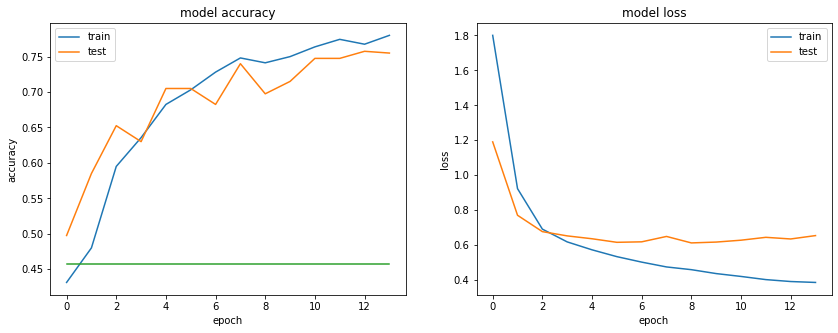

In [89]:
baseline = [max(training.groupby(['label_e','label_n']).size())/len(training)]*14

hist_plot(history, baseline)

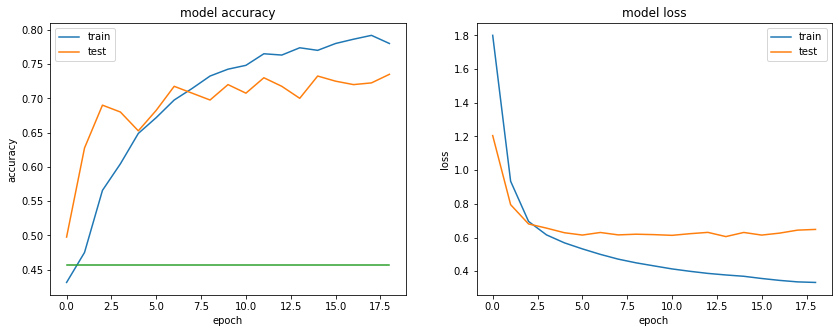

In [28]:
"""baseline for model accuracy evaluation"""
baseline = [max(training.groupby(['label_e','label_n']).size())/len(training)]*19

hist_plot(history, baseline)

### Single-label classifier

In [100]:
model_e = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vocab), embedding_dim, weights = [pretrained_weights]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                                       bias_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dense(embedding_dim, activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l1(0.001), 
                          activity_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_e.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         24360700  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 24,541,701
Trainable params: 24,541,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
moderl_e.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
opt = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
history_e = model_e.fit(x_train, e_train, validation_split=0.2, epochs=num_epoch, callbacks=callbacks, verbose=2)

In [97]:
model_e.save('emo_model1.h5')

In [105]:
model_n = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vocab), embedding_dim, weights = [pretrained_weights]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                                       bias_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dense(embedding_dim, activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l1(0.001), 
                          activity_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_n.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 100)         24360700  
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_38 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 101       
Total params: 24,541,701
Trainable params: 24,541,701
Non-trainable params: 0
_________________________________________________________________


In [106]:
model_n.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
opt = tf.keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
history_n = model_n.fit(x_train, n_train, validation_split=0.2, epochs=num_epoch, callbacks=callbacks, verbose=2)

Epoch 1/20
50/50 - 27s - loss: 1.3263 - accuracy: 0.9031 - val_loss: 0.6603 - val_accuracy: 0.8950
Epoch 2/20
50/50 - 27s - loss: 0.5975 - accuracy: 0.9031 - val_loss: 0.4855 - val_accuracy: 0.9150
Epoch 3/20
50/50 - 27s - loss: 0.4359 - accuracy: 0.9219 - val_loss: 0.4509 - val_accuracy: 0.9300
Epoch 4/20
50/50 - 27s - loss: 0.3813 - accuracy: 0.9400 - val_loss: 0.4259 - val_accuracy: 0.9325
Epoch 5/20
50/50 - 27s - loss: 0.3480 - accuracy: 0.9525 - val_loss: 0.4160 - val_accuracy: 0.9175
Epoch 6/20
50/50 - 26s - loss: 0.3137 - accuracy: 0.9675 - val_loss: 0.4045 - val_accuracy: 0.9250
Epoch 7/20
50/50 - 26s - loss: 0.2976 - accuracy: 0.9694 - val_loss: 0.3944 - val_accuracy: 0.9300
Epoch 8/20
50/50 - 27s - loss: 0.2854 - accuracy: 0.9775 - val_loss: 0.3932 - val_accuracy: 0.9250
Epoch 9/20
50/50 - 26s - loss: 0.2666 - accuracy: 0.9825 - val_loss: 0.3875 - val_accuracy: 0.9350
Epoch 10/20
50/50 - 26s - loss: 0.2487 - accuracy: 0.9862 - val_loss: 0.3907 - val_accuracy: 0.9325
Epoch 11/

In [49]:
model_n.save('nonemo_model.h5')

In [95]:
"""baseline for model accuracy evaluation"""
baseline_e = [max(training.groupby(['label_e']).size())/len(training)]*11
baseline_n = [max(training.groupby(['label_n']).size())/len(training)]*19

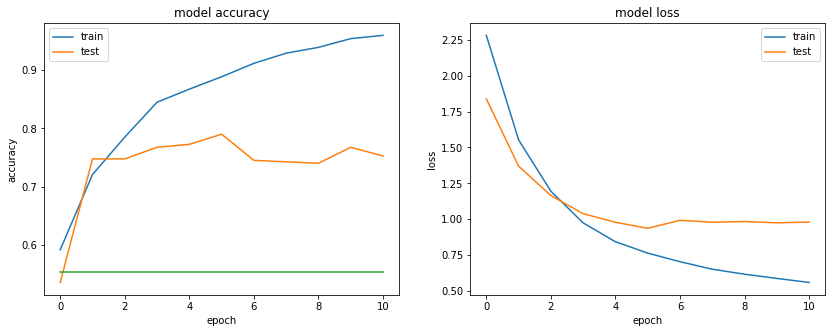

In [96]:
hist_plot(history_e, baseline_e)

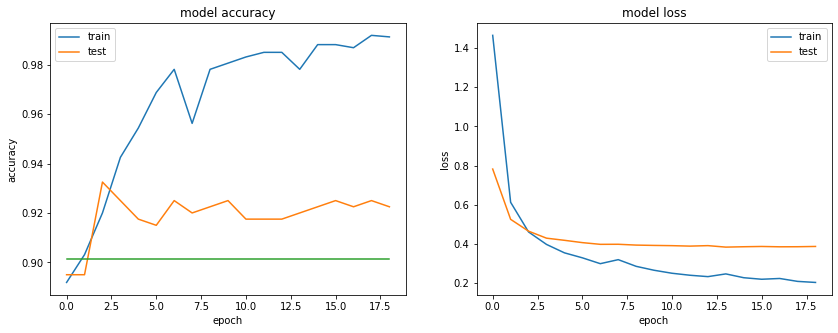

In [52]:
hist_plot(history_n, baseline_n)

### Balanced Non-emotional Sample

A more balanced sample for non-emotional support is used in this model, with baseline accuracy around .5.

This model can be used for feature learning instead of classification.

In [79]:
training_n1 = training[training['label_n'] == 1]
training_n = training[training['label_n'] == 0]
training_n1 = training_n1.sample(150)
training_n = training_n.append(training_n1)
training_n = shuffle(training_n)

x_n = word_tokenizer(training_n['content'].str.lower().tolist())
y_n = training_n[['label_n']].values
tf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, lower=True)
tf_tokenizer.fit_on_texts(x_n)

x_n = tf_tokenizer.texts_to_sequences(x_n)
x_n = tf.keras.preprocessing.sequence.pad_sequences(x_n, maxlen=max_len)

In [59]:
model_nb = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(vocab), embedding_dim, weights = [pretrained_weights]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                                       recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                                       bias_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dense(embedding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(0.001), activity_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
model_nb.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
history_nb = model_nb.fit(x_n, y_n, validation_split=0.2, epochs=num_epoch, callbacks=callbacks, verbose=2)

Epoch 1/10
7/7 - 4s - loss: 2.8446 - accuracy: 0.5714 - val_loss: 2.6891 - val_accuracy: 0.7818
Epoch 2/10
7/7 - 4s - loss: 2.6228 - accuracy: 0.7235 - val_loss: 2.5310 - val_accuracy: 0.8182
Epoch 3/10
7/7 - 4s - loss: 2.4522 - accuracy: 0.7834 - val_loss: 2.3692 - val_accuracy: 0.7636
Epoch 4/10
7/7 - 4s - loss: 2.2961 - accuracy: 0.7788 - val_loss: 2.2298 - val_accuracy: 0.8000
Epoch 5/10
7/7 - 4s - loss: 2.1354 - accuracy: 0.8571 - val_loss: 2.1154 - val_accuracy: 0.8000
Epoch 6/10
7/7 - 4s - loss: 1.9858 - accuracy: 0.9032 - val_loss: 1.9910 - val_accuracy: 0.8182
Epoch 7/10
7/7 - 4s - loss: 1.8425 - accuracy: 0.9124 - val_loss: 1.8889 - val_accuracy: 0.8364
Epoch 8/10
7/7 - 4s - loss: 1.7146 - accuracy: 0.9493 - val_loss: 1.8184 - val_accuracy: 0.8364
Epoch 9/10
7/7 - 4s - loss: 1.5981 - accuracy: 0.9631 - val_loss: 1.7435 - val_accuracy: 0.8182
Epoch 10/10
7/7 - 4s - loss: 1.4938 - accuracy: 0.9677 - val_loss: 1.7109 - val_accuracy: 0.8364


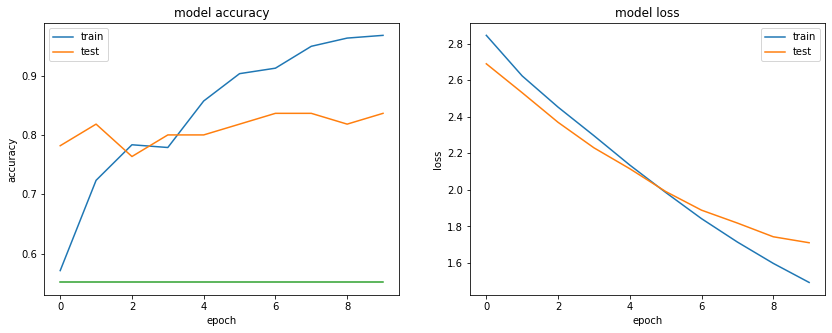

In [61]:
baseline_n = [max(training_n.groupby(['label_n']).size())/len(training_n)]*10
hist_plot(history_nb, baseline_n)

In [ ]:
model_nb.save('nonemo_model_balanced.h5')

### Classifier Testing

The models are tested on a test set of 200 posts. The accuracy is shown below.

In [ ]:
model = tf.keras.models.load_model('support_model.h5')
model_e = tf.keras.models.load_model('emo_model1.h5')
model_n = tf.keras.models.load_model('nonemo_model.h5')

In [251]:
test = pd.read_csv('data/test_LIWC_cat.csv')
test = shuffle(test)

In [252]:
x_test = word_tokenizer(test['content'].str.lower().tolist())
y_test = test[['label_e', 'label_n']].values
e_test = test['label_e'].values
n_test = test['label_n'].values
tf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, lower=True)
tf_tokenizer.fit_on_texts(x_test)

x_test = tf_tokenizer.texts_to_sequences(x_test)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [253]:
baseline = max(test.groupby(['label_e', 'label_n']).size())/len(test)
baseline_e = max(test.groupby(['label_e']).size())/len(test)
baseline_n = max(test.groupby(['label_n']).size())/len(test)

In [257]:
predicted_e = []; predicted_n = []

for i in range(len(x_test)):
    predicted = model.predict(np.expand_dims(x_test[i], 0))[0].tolist()
    pre_e = model_e.predict(np.expand_dims(x_test[i], 0))[0].tolist()
    pre_n = model_n.predict(np.expand_dims(x_test[i], 0))[0].tolist()
    predicted_e.append(predicted[0])
    predicted_n.append(predicted[1])

In [254]:
results = model.evaluate(x_test, y_test, batch_size=100)

2/2 [==============================] - 0s 142ms/step - loss: 0.7936 - accuracy: 0.6200


In [255]:
results = model_e.evaluate(x_test, e_test, batch_size=100)

2/2 [==============================] - 0s 130ms/step - loss: 1.1101 - accuracy: 0.6450


In [256]:
results = model_n.evaluate(x_test, n_test, batch_size=100)

2/2 [==============================] - 0s 129ms/step - loss: 0.5292 - accuracy: 0.8900


### Hidden layer interpretation

Probing tasks are used to interpret embeddings of this classifier in terms of linguistic features.


#### Probing task of sentences in Facebook

Existing probing tasks are used to evaluate the classifier.

    - Word content
    - Past or present
    
The result suggests no significant difference between emotional and nnon-emotional support over these linguistic features.

In [89]:
fpath = ['probing_test/past_present.txt', 'probing_test/subj_number.txt', 'probing_test/obj_number.txt', 'probing_test/coordination_inversion.txt']

task_data = {'train': {'x': [], 'y': []},
                 'dev': {'x': [], 'y': []},
                 'test': {'x': [], 'y': []}}
tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}

with io.open(fpath[0], 'r', encoding='utf-8') as f:
    for line in f:
        line = line.rstrip().split('\t')
        task_data[tok2split[line[0]]]['x'].append(line[-1].split())
        task_data[tok2split[line[0]]]['y'].append(line[1])

labels = sorted(np.unique(task_data['train']['y']))
tok2label = dict(zip(labels, range(len(labels))))
nclasses = len(tok2label)

for split in task_data:
    for i, y in enumerate(task_data[split]['y']):
        task_data[split]['y'][i] = tok2label[y]

sent = task_data['test']['x']
for i in range(len(sent)):
    for k in range(len(sent[i])):
        sent[i][k] = sent[i][k].lower()
        
tf_tokenizer.fit_on_texts(sent)
sent = tf_tokenizer.texts_to_sequences(sent)
sent = tf.keras.preprocessing.sequence.pad_sequences(sent, maxlen=max_len)

In [90]:
"""tense"""
"""H: posts with emotional support usually uses present tense, posts without usually uses past tense"""

predicted_e = []
for i in range(len(sent)):
    pre = model_e.predict(np.expand_dims(sent[i], 0))[0]
    if pre < .5:
        label = 0
    else:
        label = 1
    predicted_e.append(label)
    
pp = task_data['test']['y']

In [91]:
pp_e = [0]*4
for i in range(len(sent)):
    if pp[i] == 0 and predicted_e[i] == 0:
        pp_e[0] += 1
    elif pp[i] == 0 and predicted_e[i] == 1:
        pp_e[1] += 1
    elif pp[i] == 1 and predicted_e[i] == 0:
        pp_e[2] += 1
    elif pp[i] == 1 and predicted_e[i] == 1:
        pp_e[3] += 1

In [92]:
chisquare([pp_e[0], pp_e[1]], [pp_e[2], pp_e[3]])

Power_divergenceResult(statistic=14.256642125157665, pvalue=0.00015949692417089486)

In [93]:
pp_e

[2848, 2152, 2715, 2285]

In [94]:
predicted_n = []
for i in range(len(sent)):
    pre = model_nb.predict(np.expand_dims(sent[i], 0))[0]
    if pre < .5:
        label = 0
    else:
        label = 1
    predicted_n.append(label)

In [95]:
pp_n = [0]*4
for i in range(len(sent)):
    if pp[i] == 0 and predicted_n[i] == 0:
        pp_n[0] += 1
    elif pp[i] == 0 and predicted_n[i] == 1:
        pp_n[1] += 1
    elif pp[i] == 1 and predicted_n[i] == 0:
        pp_n[2] += 1
    elif pp[i] == 1 and predicted_n[i] == 1:
        pp_n[3] += 1

In [96]:
chisquare([pp_n[0]/len(sent), pp_n[1]], [pp_n[2], pp_n[3]])

Power_divergenceResult(statistic=47.14178410071862, pvalue=6.603286448814048e-12)

In [97]:
pp_n

[4360, 640, 4505, 495]

### Probing task with LIWC

LIWC results are generated for all posts in the test set. Each LIWC variable is compared with the predicted result using correlation.

Significant correlations are shown below for emotional and non-emotional support. These might be the features that the model is able to recognize in the hidden layer, to certain degree.

In [258]:
nonemo_LIWC = []
emo_LIWC = []
cb_LIWC = []
for i in range(4, 97):
    corr_e = pearsonr(predicted_e, test.iloc[:,i].tolist())
    corr_n = pearsonr(predicted_n, test.iloc[:,i].tolist())
    if corr_e[1] < .05:
        emo_LIWC.append([test.columns[i], corr_e[0], corr_e[1]])
    if corr_n[1] < .05:
        nonemo_LIWC.append([test.columns[i], corr_n[0], corr_n[1]])
    if corr_e[1] < .05 and corr_n[1] < .05:
        cb_LIWC.append([test.columns[i], corr_n[0], corr_n[1], corr_e[0], corr_e[1]])

In [259]:
nonemo_LIWC.sort(key = lambda x: x[2])
emo_LIWC.sort(key = lambda x: x[2])
cb_LIWC.sort(key = lambda x: x[1])

In [260]:
nonemo_LIWC

[['AllPunc', -0.5079463931324072, 1.6241950106127043e-14],
 ['label_n', 0.5060428622336045, 2.1081847173658826e-14],
 ['posemo', -0.4798250205003724, 6.52554450907883e-13],
 ['affect', -0.44436656430057103, 4.355230089738532e-11],
 ['function.', 0.43720817364669684, 9.605016999338581e-11],
 ['Exclam', -0.41290421851965514, 1.231861447175569e-09],
 ['prep', 0.40783027837616864, 2.0462229495526038e-09],
 ['verb', 0.3248939706673927, 2.6809729572856728e-06],
 ['differ', 0.31906442188104167, 4.126631469777023e-06],
 ['Sixltr', -0.3094033819380506, 8.269716824292546e-06],
 ['adj', -0.3074663591108229, 9.478903962235965e-06],
 ['tentat', 0.3049070084123374, 1.1335149051749471e-05],
 ['WPS', 0.3019577542446997, 1.3900494860296484e-05],
 ['you', -0.2910429812344487, 2.901778206874018e-05],
 ['cogproc', 0.27651517108450324, 7.383938288549062e-05],
 ['negate', 0.2622890726472598, 0.00017544364399990563],
 ['relig', -0.2574450684896825, 0.00023302326643649514],
 ['focuspresent', 0.248118364786386

In [261]:
emo_LIWC

[['you', 0.29833189266005394, 1.7809436783542235e-05],
 ['label_n', -0.27319968229561964, 9.072940295566542e-05],
 ['Clout', 0.22372204184480649, 0.001449850064863908],
 ['posemo', 0.21783292579904587, 0.0019443130855085415],
 ['affect', 0.21489923038694825, 0.002244098203484102],
 ['social', 0.1988657452014769, 0.0047575121339279765],
 ['differ', -0.1779860258800045, 0.011685867764650764],
 ['space', -0.17177083391841405, 0.015012212577027156],
 ['AllPunc', 0.16941033851519235, 0.016477342833850623],
 ['certain', 0.16423008627401228, 0.02013583695364544],
 ['negate', -0.1587916756177375, 0.02471386002187873],
 ['ppron', 0.1561428953971825, 0.0272503279447674],
 ['Exclam', 0.14086281307608228, 0.04664101189569067]]

In [262]:
cb_LIWC

[['AllPunc',
  -0.5079463931324072,
  1.6241950106127043e-14,
  0.16941033851519235,
  0.016477342833850623],
 ['posemo',
  -0.4798250205003724,
  6.52554450907883e-13,
  0.21783292579904587,
  0.0019443130855085415],
 ['affect',
  -0.44436656430057103,
  4.355230089738532e-11,
  0.21489923038694825,
  0.002244098203484102],
 ['Exclam',
  -0.41290421851965514,
  1.231861447175569e-09,
  0.14086281307608228,
  0.04664101189569067],
 ['you',
  -0.2910429812344487,
  2.901778206874018e-05,
  0.29833189266005394,
  1.7809436783542235e-05],
 ['certain',
  -0.18468007939873282,
  0.008845764046907269,
  0.16423008627401228,
  0.02013583695364544],
 ['space',
  0.18493192315535717,
  0.008752037560532562,
  -0.17177083391841405,
  0.015012212577027156],
 ['negate',
  0.2622890726472598,
  0.00017544364399990563,
  -0.1587916756177375,
  0.02471386002187873],
 ['differ',
  0.31906442188104167,
  4.126631469777023e-06,
  -0.1779860258800045,
  0.011685867764650764],
 ['label_n',
  0.50604286223